In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [3]:
source('main.R')

house_prices$helpers$import_libs()

combined_dataset <- house_prices$helpers$load_data()

In [4]:
combined_dataset %>% dim
combined_dataset %>% filter(dataSource == "train") %>% dim
combined_dataset %>% filter(dataSource == "test") %>% dim

[1] 2919   82

[1] 1460   82

[1] 1459   82

In [6]:
categ_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_character_colnames(combined_dataset), SalePrice, -dataSource)

numeric_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_numeric_colnames(combined_dataset), -Id)

In [7]:
categ_data %>% glimpse(50)

Observations: 2,919
Variables: 45
$ Alley         <chr> NA, NA, NA, NA, NA, NA,...
$ BldgType      <chr> "1Fam", "1Fam", "1Fam",...
$ BsmtCond      <chr> "TA", "TA", "TA", "Gd",...
$ BsmtExposure  <chr> "No", "Gd", "Mn", "No",...
$ BsmtFinType1  <chr> "GLQ", "ALQ", "GLQ", "A...
$ BsmtFinType2  <chr> "Unf", "Unf", "Unf", "U...
$ BsmtQual      <chr> "Gd", "Gd", "Gd", "TA",...
$ CentralAir    <chr> "Y", "Y", "Y", "Y", "Y"...
$ Condition1    <chr> "Norm", "Feedr", "Norm"...
$ Condition2    <chr> "Norm", "Norm", "Norm",...
$ Electrical    <chr> "SBrkr", "SBrkr", "SBrk...
$ ExterCond     <chr> "TA", "TA", "TA", "TA",...
$ Exterior1st   <chr> "VinylSd", "MetalSd", "...
$ Exterior2nd   <chr> "VinylSd", "MetalSd", "...
$ ExterQual     <chr> "Gd", "TA", "Gd", "TA",...
$ Fence         <chr> NA, NA, NA, NA, NA, "Mn...
$ FireplaceQu   <chr> NA, "TA", "TA", "Gd", "...
$ Foundation    <chr> "PConc", "CBlock", "PCo...
$ Functional    <chr> "Typ", "Typ", "Typ", "T...
$ GarageCond    <chr> "TA", "TA", "

In [8]:
numeric_data %>% glimpse(50)

Observations: 2,919
Variables: 36
$ BedroomAbvGr  <int> 3, 3, 3, 3, 4, 1, 3, 3,...
$ BsmtFinSF1    <int> 706, 978, 486, 216, 655...
$ BsmtFinSF2    <int> 0, 0, 0, 0, 0, 0, 0, 32...
$ BsmtFullBath  <int> 1, 0, 1, 1, 1, 1, 1, 1,...
$ BsmtHalfBath  <int> 0, 1, 0, 0, 0, 0, 0, 0,...
$ BsmtUnfSF     <int> 150, 284, 434, 540, 490...
$ EnclosedPorch <int> 0, 0, 0, 272, 0, 0, 0, ...
$ Fireplaces    <int> 0, 1, 1, 1, 1, 0, 1, 2,...
$ FullBath      <int> 2, 2, 2, 1, 2, 1, 2, 2,...
$ GarageArea    <int> 548, 460, 608, 642, 836...
$ GarageCars    <int> 2, 2, 2, 3, 3, 2, 2, 2,...
$ GarageYrBlt   <int> 2003, 1976, 2001, 1998,...
$ GrLivArea     <int> 1710, 1262, 1786, 1717,...
$ HalfBath      <int> 1, 0, 1, 0, 1, 1, 0, 1,...
$ KitchenAbvGr  <int> 1, 1, 1, 1, 1, 1, 1, 1,...
$ LotArea       <int> 8450, 9600, 11250, 9550...
$ LotFrontage   <int> 65, 80, 68, 60, 84, 85,...
$ LowQualFinSF  <int> 0, 0, 0, 0, 0, 0, 0, 0,...
$ MasVnrArea    <int> 196, 0, 162, 0, 350, 0,...
$ MiscVal       <int> 0, 0, 0, 0, 0

In [9]:
entropy = function(col) {
    counts = table(col, useNA="ifany")
    freqs <- counts / length(col)
    -sum(freqs * log2(freqs))
}

In [10]:
categ_data %>%
select(-SalePrice) %>%
purrr::map(entropy) %>% 
as_data_frame %>% 
gather(var, entropy) %>%
arrange(entropy) -> categ_vars_by_entropy

categ_vars_by_entropy %>% head
categ_vars_by_entropy %>% tail

var,entropy
Utilities,0.01262749
PoolQC,0.03820308
Street,0.03850369
Condition2,0.10643374
RoofMatl,0.13851938
Heating,0.13977521


var,entropy
HouseStyle,1.836382
BsmtFinType1,2.454724
Exterior1st,2.723429
Exterior2nd,2.800720
MSSubClass,2.920021
Neighborhood,4.212100


In [11]:
numeric_data %>%
select(-SalePrice) %>%
purrr::map(entropy) %>% 
as_data_frame %>% 
gather(var, entropy) %>%
arrange(entropy) -> numeric_vars_by_entropy

numeric_vars_by_entropy %>% head
numeric_vars_by_entropy %>% tail

var,entropy
PoolArea,0.05767714
X3SsnPorch,0.15876902
LowQualFinSF,0.17326513
KitchenAbvGr,0.28095915
BsmtHalfBath,0.34480765
MiscVal,0.37490332


var,entropy
GarageArea,7.968793
TotalBsmtSF,9.348757
BsmtUnfSF,9.390885
X1stFlrSF,9.601608
GrLivArea,9.882939
LotArea,10.400602


In [27]:
combined_dataset %>% 
select(price=SalePrice) %>% 
na.omit %>%
mutate(
    price.log = log(price)
) %>%
gather(var, value) %>%
group_by(var) %>%
mutate(
    normed_value = (value - mean(value)) / sd(value)
) -> target_normal_paper

In [29]:
target_normal_paper %>% arrange(var, value) %>% top_n(3, value)

var,value,normed_value
price,625000.00000,5.589940
price,745000.00000,7.100466
price,755000.00000,7.226343
price.log,13.34551,3.308173
price.log,13.52114,3.747857
price.log,13.53447,3.781237


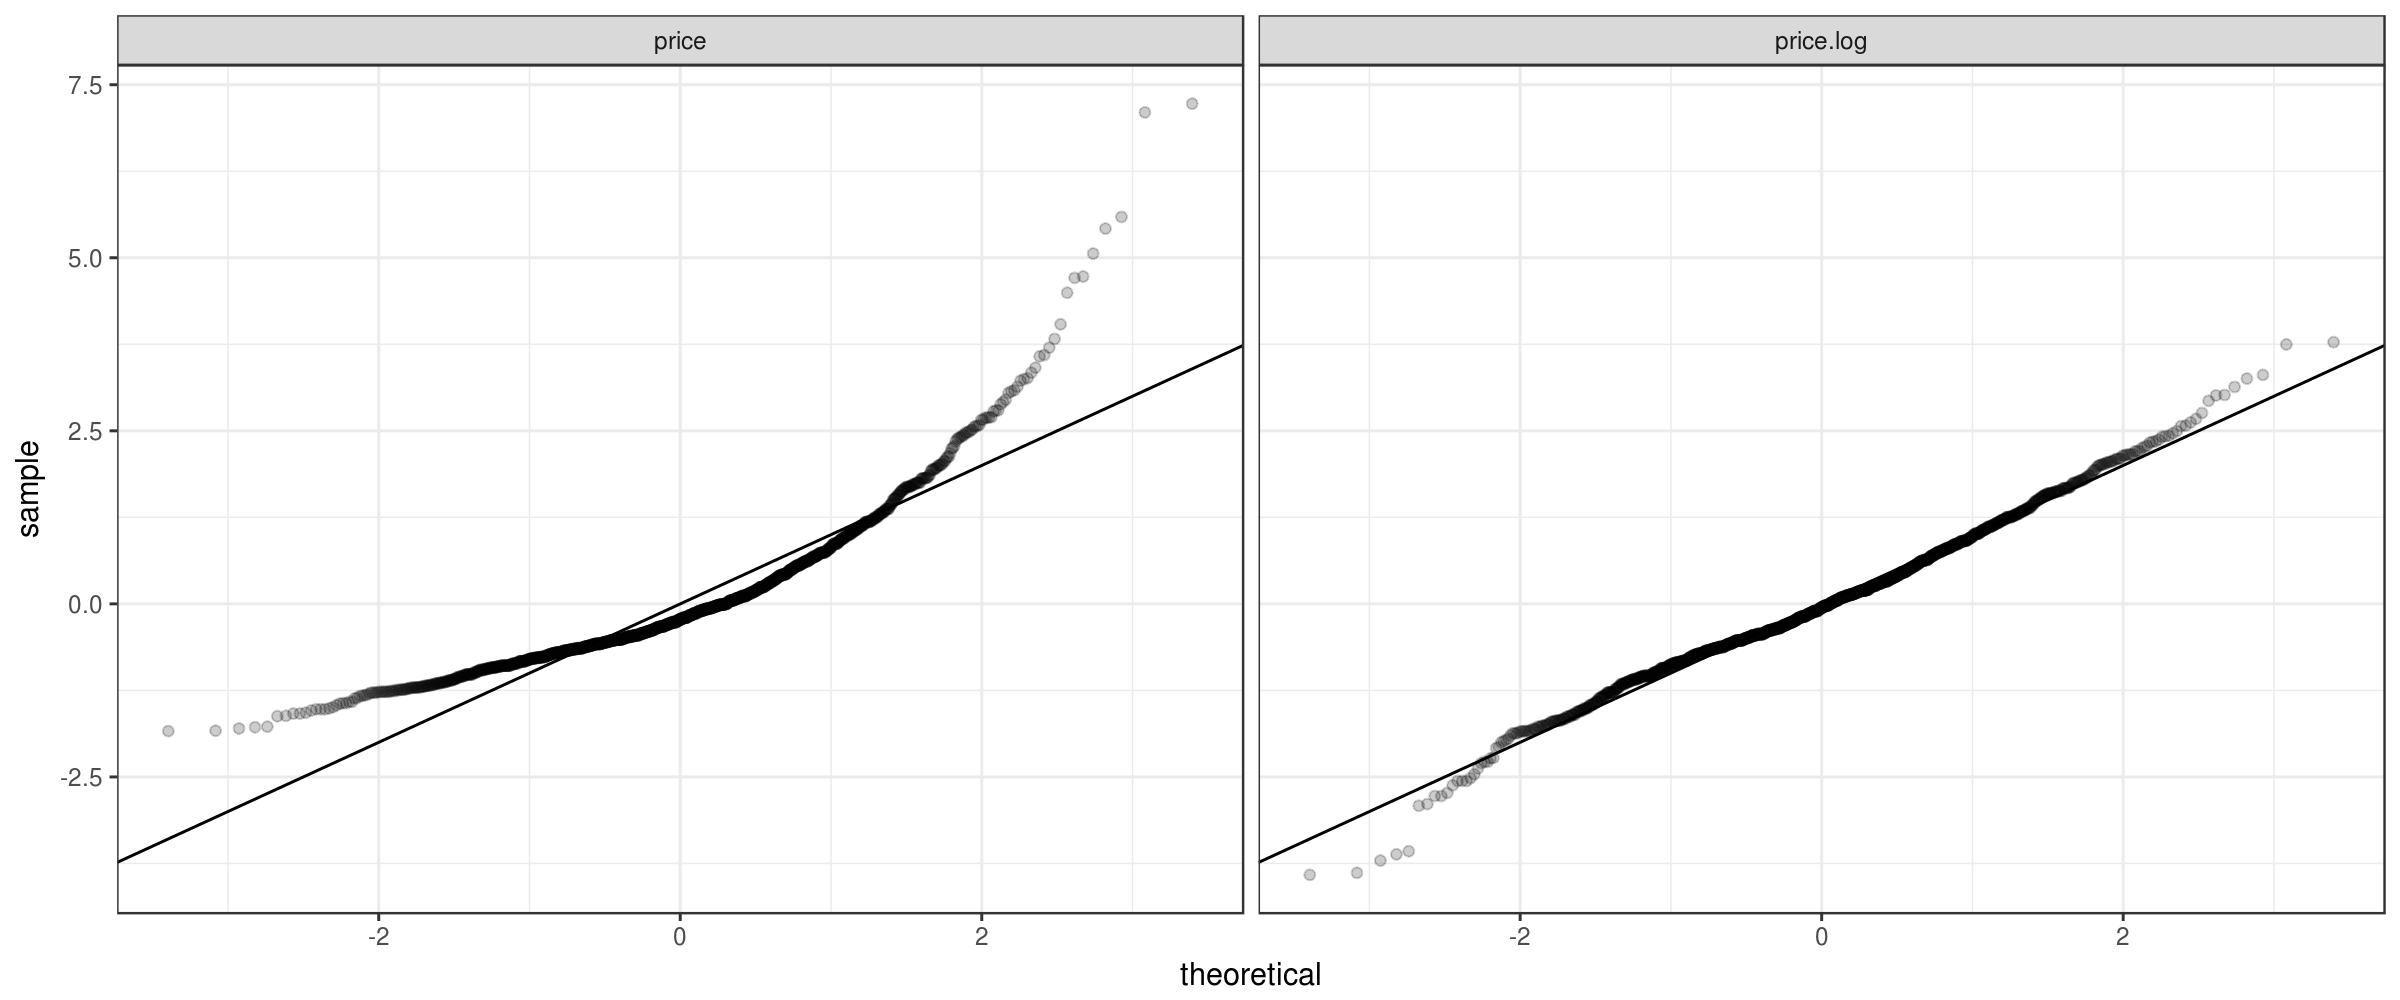

In [43]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res=200)

target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw()

In [49]:
CategVarsVsTarget.get_precalculated <- function(categ_data) {
    
    global_std <- sd(categ_data[,'SalePrice'][[1]], na.rm=TRUE)

    categ_data %>%
    filter(!is.na(SalePrice)) %>%
    gather(var, value, -SalePrice) %>%
    group_by(var, value) %>%
    summarise(
        n = n(),
        mean = mean(SalePrice),
        std = ifelse(n > 1, sd(SalePrice), global_std)
    ) %>%
    mutate(
        freq = n / sum(n)
    ) %>% 
    arrange(var, mean) %>%
    mutate(
        lead_mean = lead(mean, 1),
        lead_freq = lead(freq, 1),
        lead_std  = lead(std, 1)
    )    
}

CategVarsVsTarget.get_separation <- function (precalculated) {
    precalculated %>%
    mutate(
        additive = (lead_mean - mean)^2 / (std^2/freq + lead_std^2/lead_freq)
    ) %>%
    summarise(
        score = sum(additive, na.rm = TRUE)
    ) %>%
    arrange(score)   
}

precalculated <- CategVarsVsTarget.get_precalculated(categ_data) 
categ_vars_by_target_separation <- CategVarsVsTarget.get_separation(precalculated)

precalculated %>% head(10)

var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
Alley,Grvl,50,122219.1,34780.781,0.034246575,168000.6,0.02808219,38370.38
Alley,Pave,41,168000.6,38370.375,0.028082192,183452.1,0.93767123,80667.15
Alley,NA,1369,183452.1,80667.145,0.937671233,NA,NA,NA
BldgType,2fmCon,31,128432.3,35458.545,0.021232877,133541.1,0.03561644,27833.25
BldgType,Duplex,52,133541.1,27833.249,0.035616438,135911.6,0.02945205,41013.22
BldgType,Twnhs,43,135911.6,41013.222,0.029452055,181959.3,0.07808219,60626.11
BldgType,TwnhsE,114,181959.3,60626.109,0.078082192,185763.8,0.83561644,82648.50
BldgType,1Fam,1220,185763.8,82648.503,0.835616438,NA,NA,NA
BsmtCond,Po,2,64000.0,4242.641,0.001369863,105652.9,0.02534247,29278.69
BsmtCond,NA,37,105652.9,29278.695,0.025342466,121809.5,0.03082192,43467.80


In [50]:
categ_vars_by_target_separation %>% head(5)

var,score
Utilities,0.0002047587
LotConfig,0.0005070409
Functional,0.0006479951
PoolQC,0.0010659277
Condition2,0.0012226735


In [51]:
categ_vars_by_target_separation %>% tail(5)

var,score
CentralAir,0.2042301
GarageFinish,0.2756040
BsmtQual,0.4210981
KitchenQual,0.4775291
ExterQual,0.4871526


In [298]:
order_factor_by_target <- function(df, factor_var, target_var) {
    
    factor_var <- enquo(factor_var)
    factor_var_char <- as.character(factor_var)[2]
    target_var <- enquo(target_var)
    
    temp <-
        categ_data %>%
        filter(!is.na(!!target_var)) %>%
        select(!!factor_var, !!target_var)

    factor_ordering <- 
        temp %>%
        group_by(!!factor_var) %>%
        summarise(
            n = n(),
            mean = mean(!!target_var)
        ) %>%
        arrange(mean) %>%
        select(!!factor_var) %>%
        `[[`(1)
    
    temp %>%
    mutate(
        !!factor_var_char := factor(
            !!factor_var,
            levels=factor_ordering
        )
    )
}

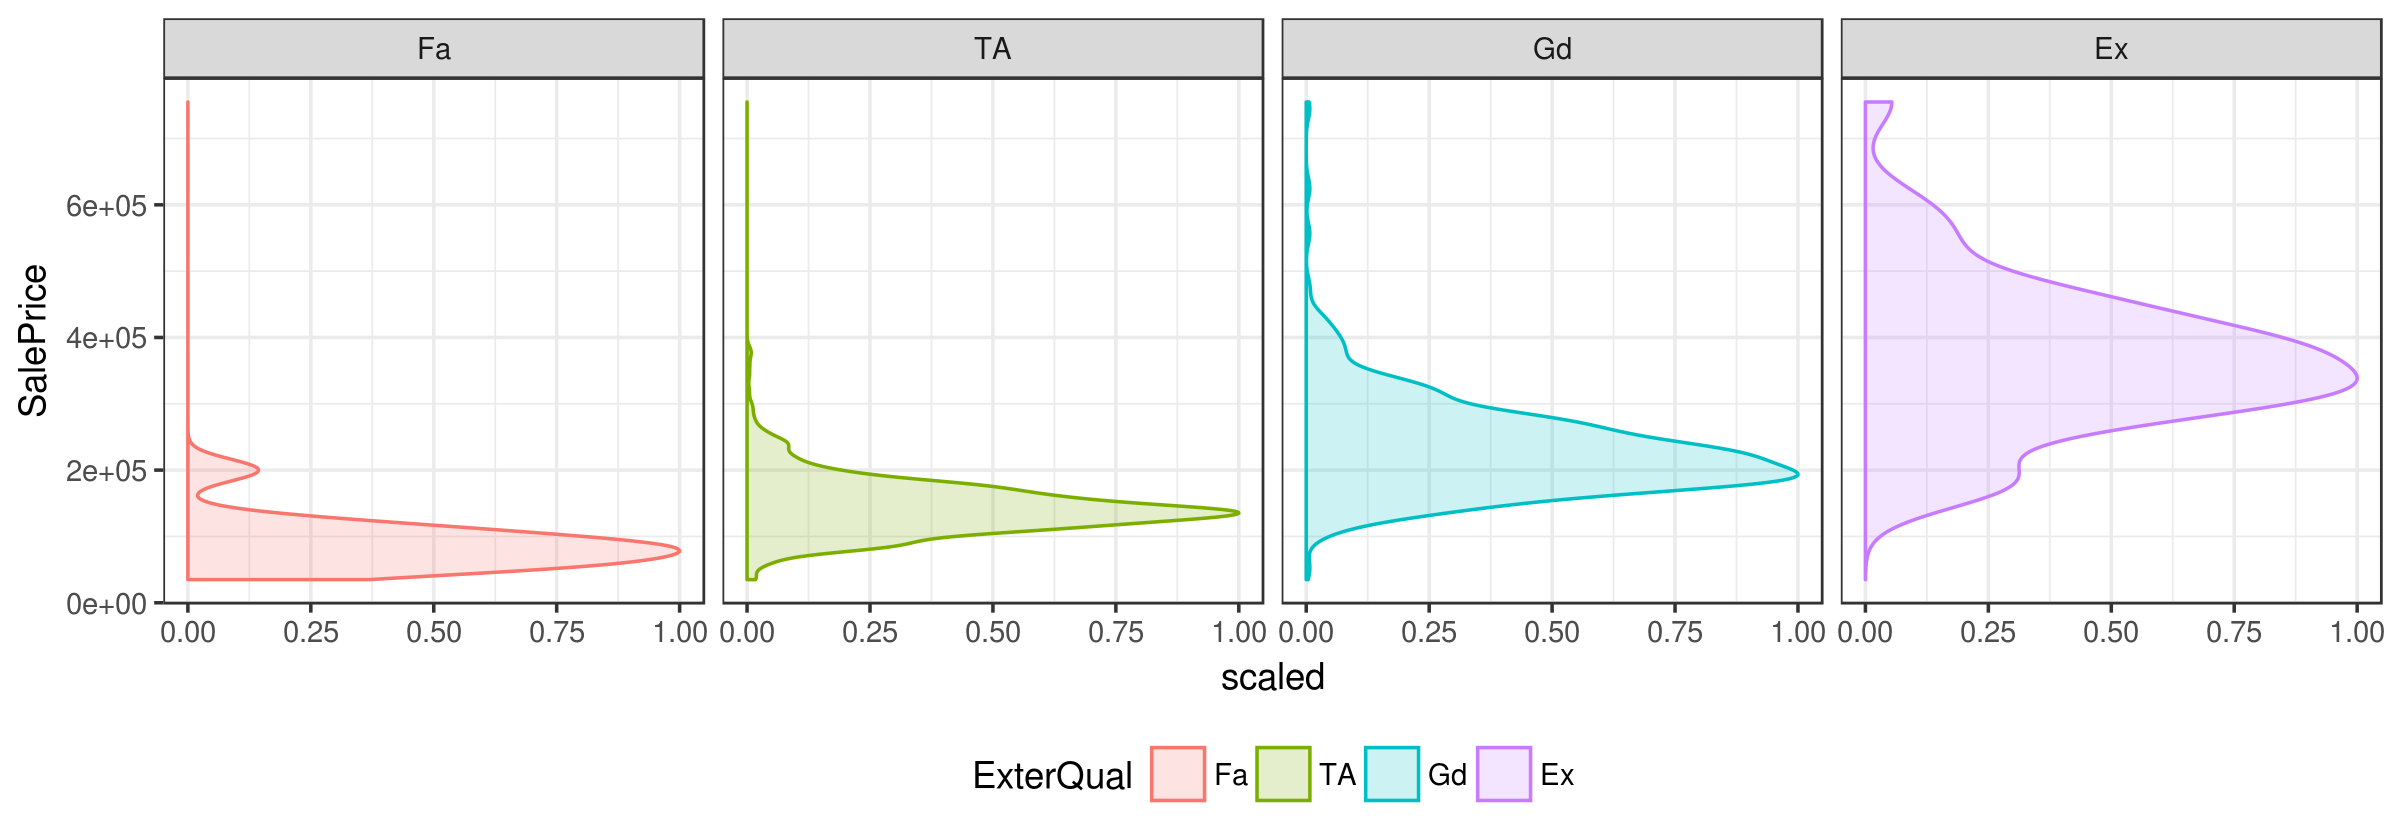

In [326]:
options(repr.plot.width = 10, repr.plot.height = 3.5, repr.plot.res=240)

order_factor_by_target(categ_data, ExterQual, SalePrice) %>%
ggplot(aes(SalePrice, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom")

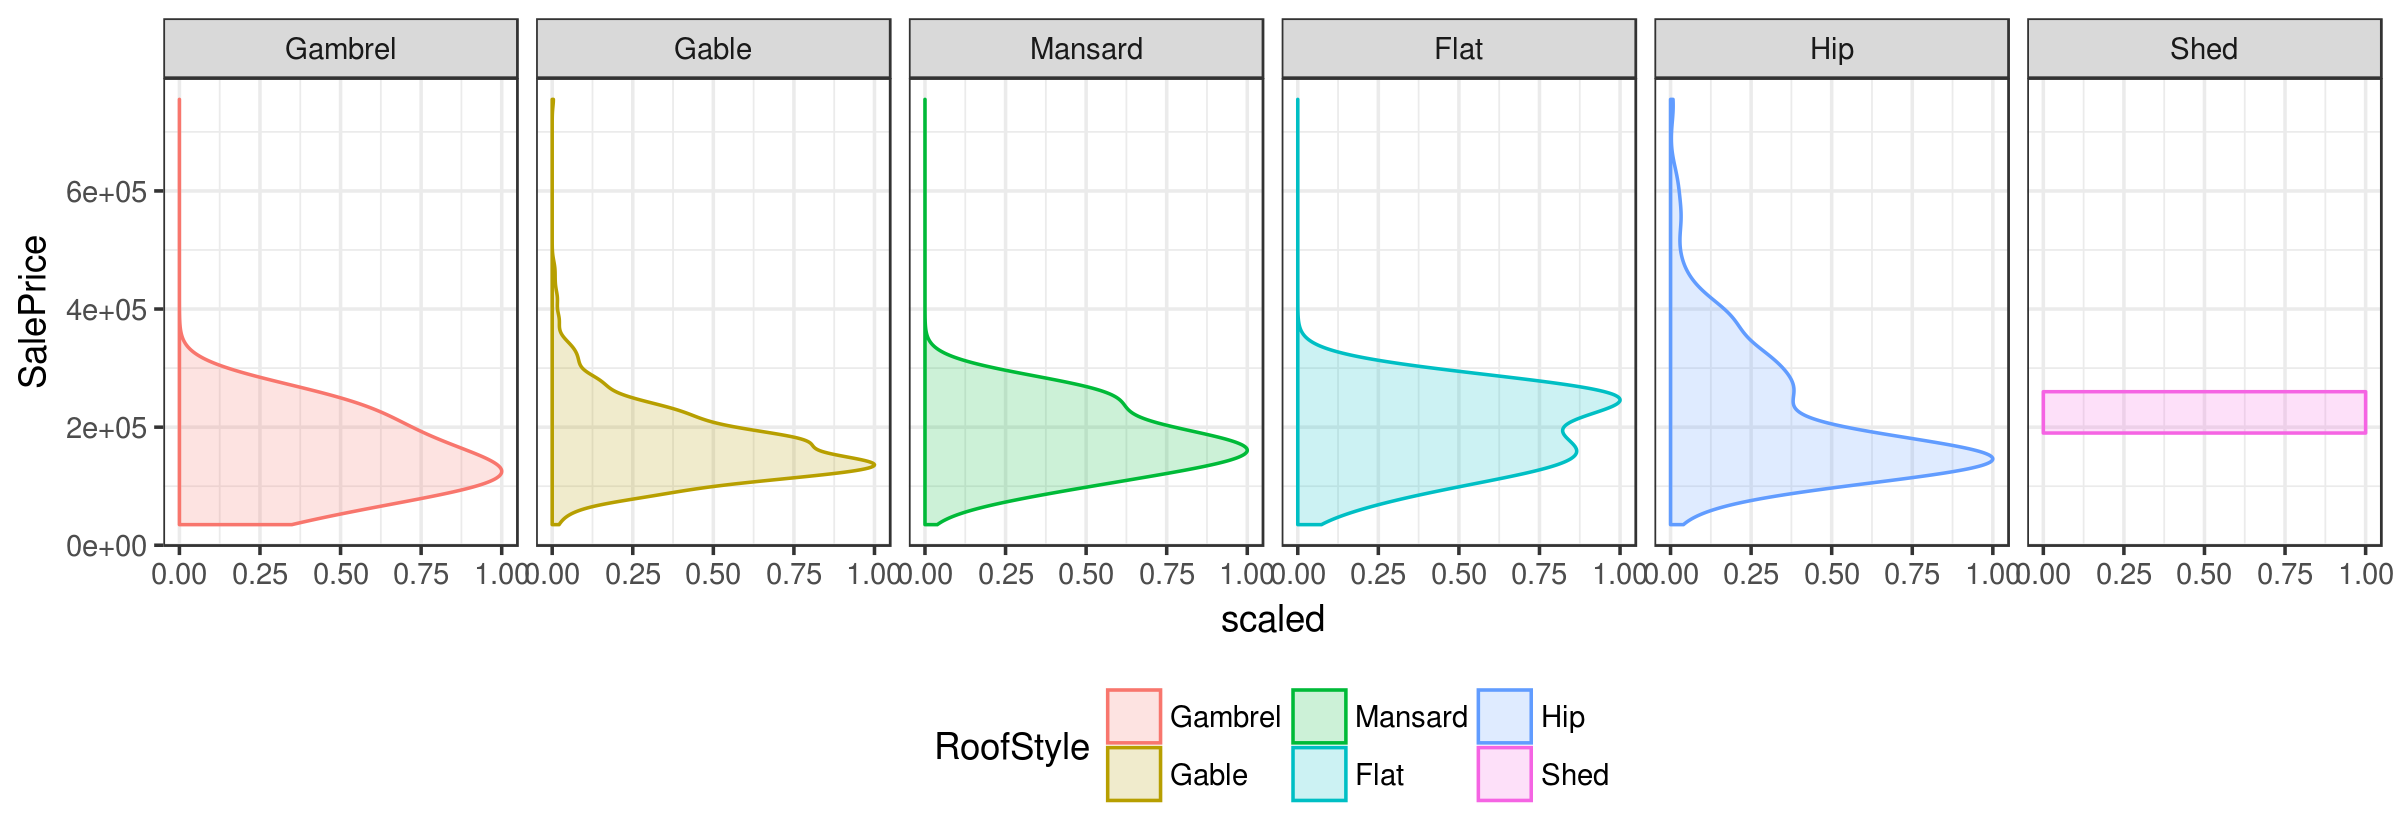

In [176]:
options(repr.plot.width = 10, repr.plot.height = 3.5, repr.plot.res=240)

order_factor_by_target(categ_data, RoofStyle, SalePrice) %>%
ggplot(aes(SalePrice, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom")

In [200]:
categ_data %>%
filter(!is.na(SalePrice)) %>%
gather(var, value, -SalePrice) %>%
group_by(var) %>%
nest %>%
mutate(
    mod = map(data, ~lm(SalePrice ~ value, .)),
    glance = map(mod, broom::glance),
    r2 = map_dbl(glance, 'r.squared')
) %>%
select(var, r2) %>%
arrange(r2) -> categ_vars_by_r2

In [202]:
categ_vars_by_r2 %>% head(5)
categ_vars_by_r2 %>% tail(5)

var,r2
Utilities,0.0002048991
Street,0.0016839152
LandSlope,0.0026816256
BsmtFinType2,0.0094523506
Condition2,0.0098991607


var,r2
PoolQC,0.4486514
BsmtQual,0.4537561
KitchenQual,0.4565986
ExterQual,0.4773878
Neighborhood,0.5455750


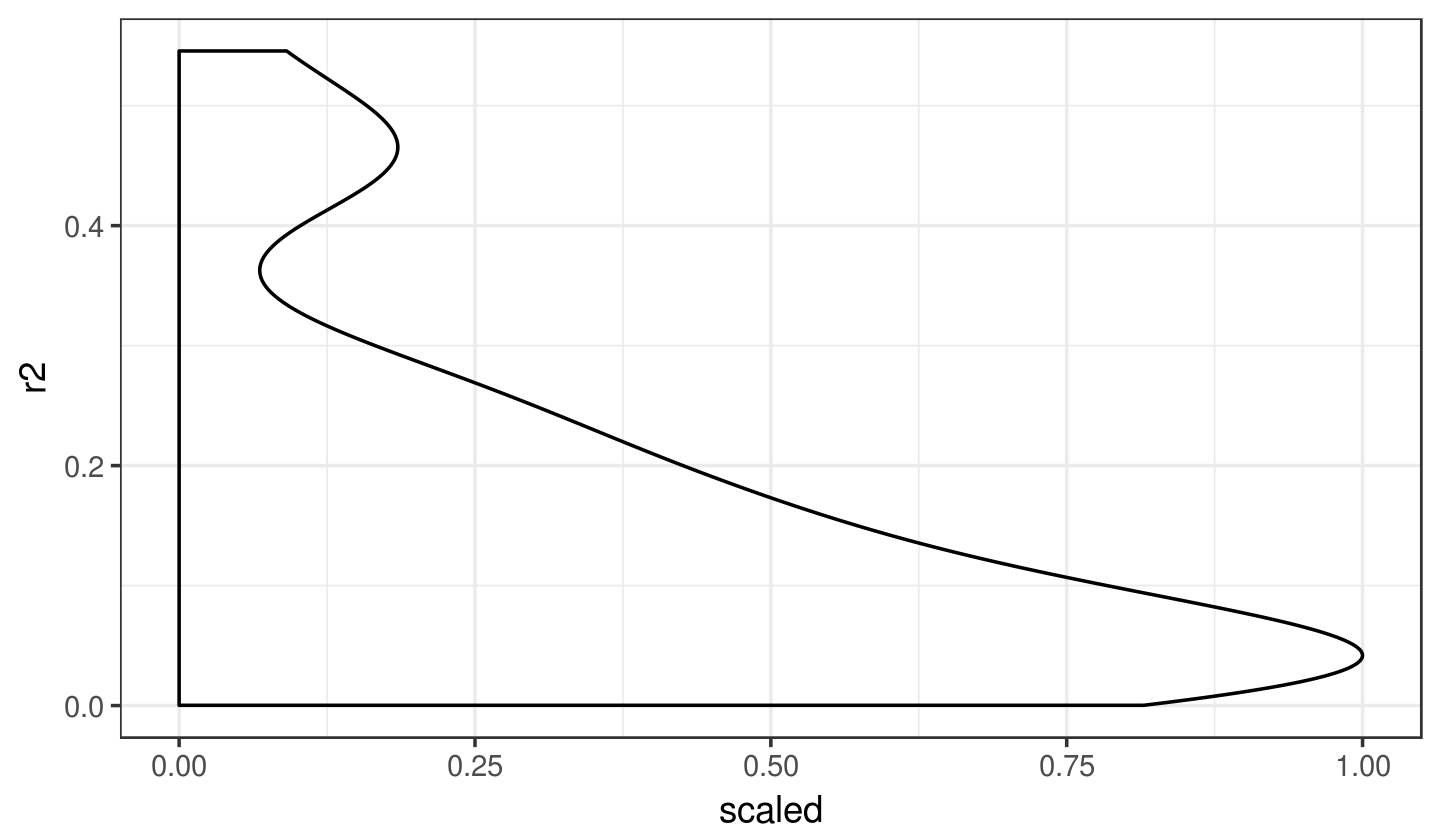

In [237]:
options(repr.plot.width = 6, 
        repr.plot.height = 3.5, 
        repr.plot.res=240)

categ_vars_by_r2 %>%
ggplot(aes(r2)) +
geom_density(aes(y=..scaled..), alpha=.2) +
coord_flip() +
theme_bw()

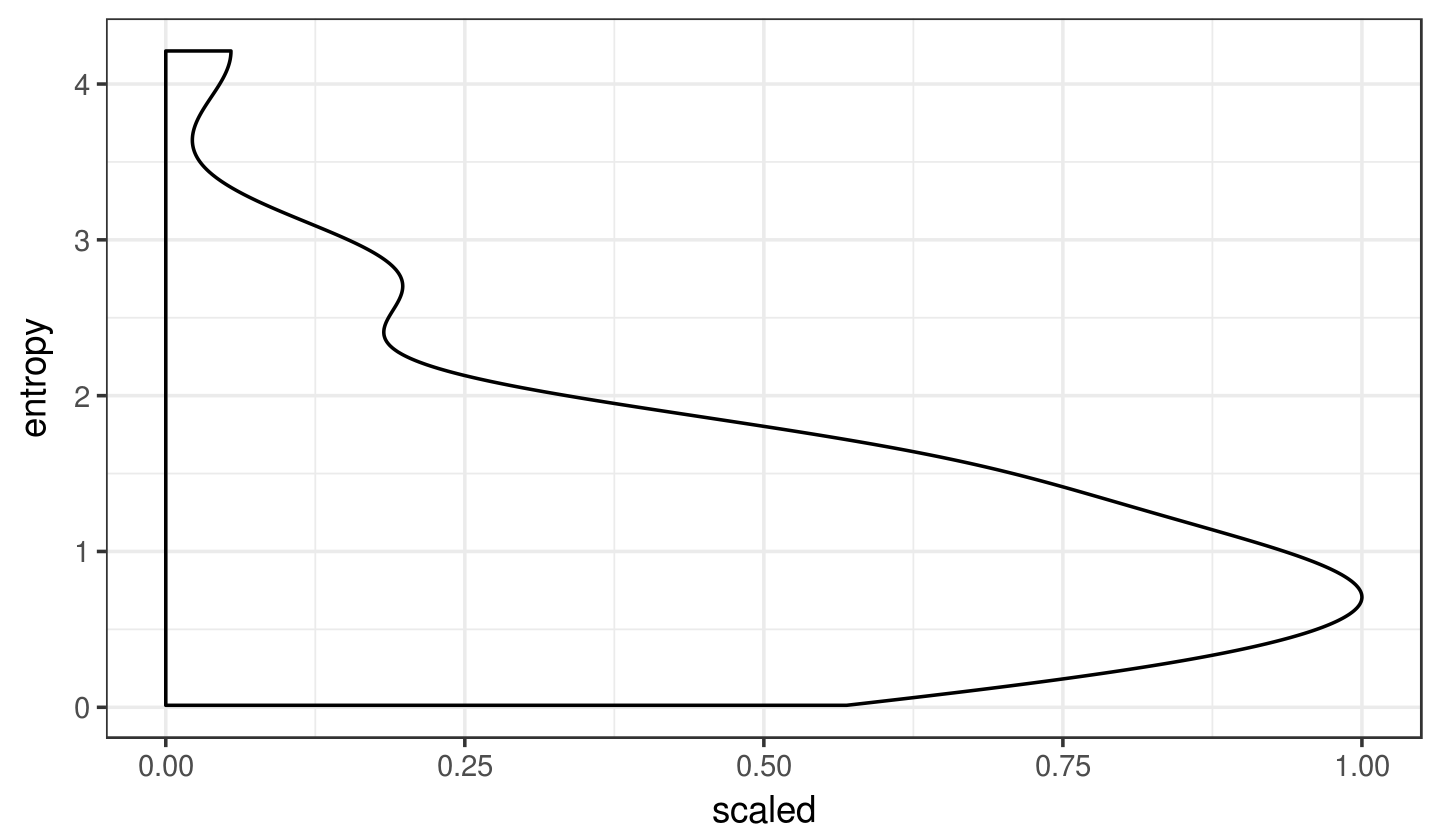

In [239]:
options(repr.plot.width = 6, 
        repr.plot.height = 3.5, 
        repr.plot.res=240)

categ_vars_by_entropy %>%
ggplot(aes(entropy)) +
geom_density(aes(y=..scaled..), alpha=.2) +
coord_flip() +
theme_bw()

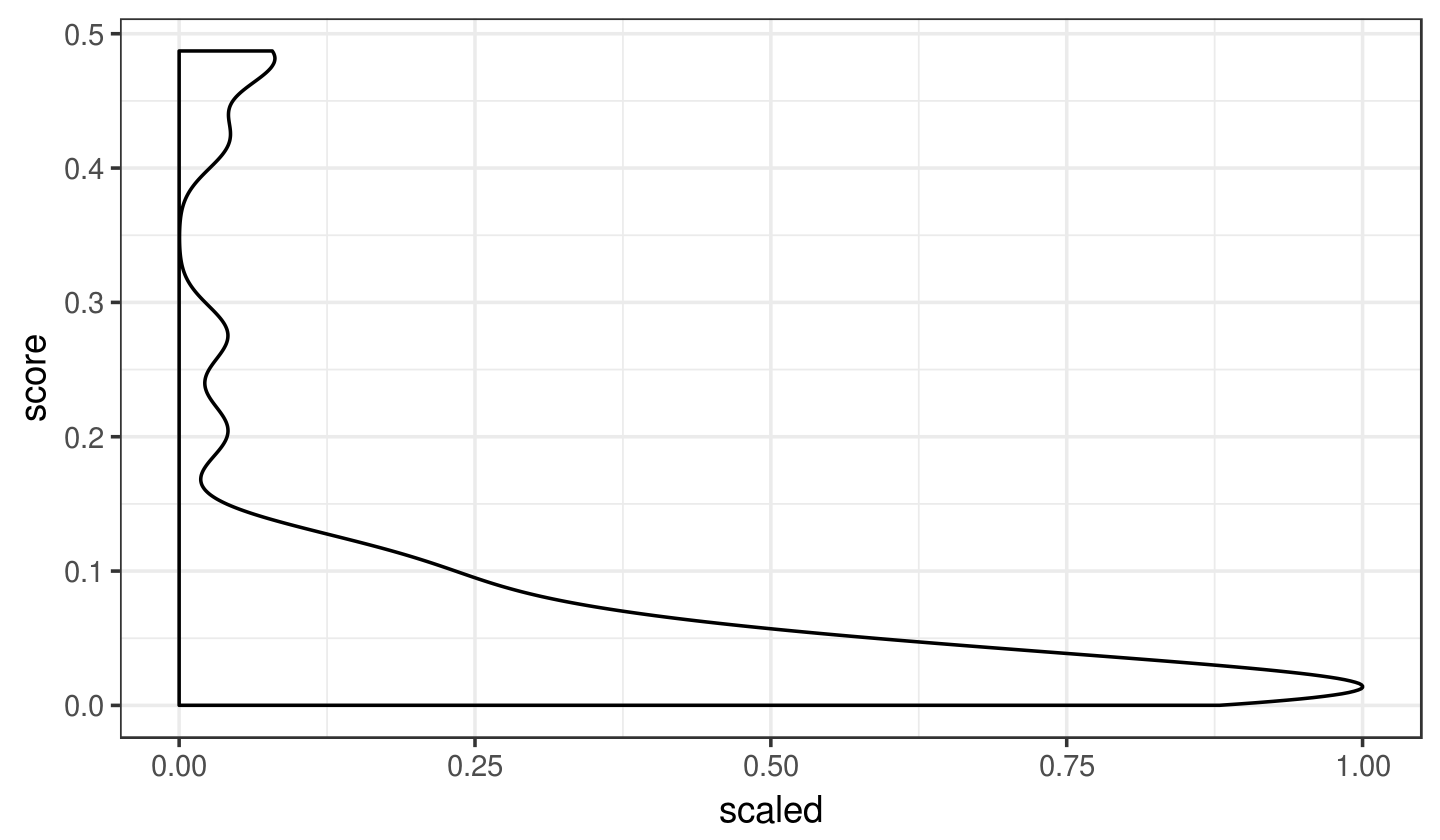

In [241]:
options(repr.plot.width = 6, 
        repr.plot.height = 3.5, 
        repr.plot.res=240)

categ_vars_by_target_separation %>%
ggplot(aes(score)) +
geom_density(aes(y=..scaled..), alpha=.2) +
coord_flip() +
theme_bw()

In [278]:
categ_vars_by_r2 %>% 
    filter(r2 < quantile(r2, 0.5)) %>% `[[`('var') -> x1

categ_vars_by_entropy %>% 
    filter(entropy < quantile(entropy, 0.5)) %>% `[[`('var') -> x2

categ_vars_by_target_separation %>% 
    filter(score < quantile(score, 0.5)) %>% `[[`('var') -> x3

Reduce(intersect, list(x1, x2, x3), )

[1] "Utilities"    "Street"       "LandSlope"    "BsmtFinType2" "Condition2"  
 [6] "Functional"   "LandContour"  "GarageCond"   "RoofMatl"     "Condition1"  
[11] "RoofStyle"    "Electrical"